In [1]:
import sys
import os
from pathlib import Path
from hydra import initialize, compose
initialize(config_path="../confs", job_name="notebook")

sys.path.append(os.path.abspath("../src"))
# We change the working directory to the root of the project
# Run this only once
root_path = Path.cwd().parent
os.chdir(root_path)
sys.path.append(root_path / "src")

/tmp/ipykernel_157460/1901343020.py:5: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path="../confs", job_name="notebook")


In [11]:
from src.utils import torch_to_pil
# from src.character_linking.feature_matching import featureMatching
# from src.character_linking.params import HOGParameters, featureMatchingParameters, fullHOGOutput, featureMatchingOutputs
from src.utils import connectedComponent
from src.patch_processing.patch_extraction import extract_patches

# from notebook_utils.viz import show_random_sample, savefig
# from notebook_utils.descriptor import compute_hog, visualize_hog
from einops import rearrange
import torch

import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm

from PIL import Image

image_folder = Path('data/datasets/book_small')
# comps_folder = Path('outputs/extraction/book1/components/')
comps_folder = Path('outputs/book_small/components/')


assert image_folder.exists()
assert comps_folder.exists()
files = next(os.walk(image_folder))[2]

/home/mathis/anaconda3/envs/projetOCR/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Pipeline

This notebook presents the pipeline used to preprocess the images and compute character-wise features. We:

1. Preprocess the images using the Binary Vectorization Method by He. et al
2. Render them into a grid, aligning the barycenters with the middle of the canvas
3. Compute their Histogram of Oriented Gradients (HOG)
4. Predict the character using EasyOCR's Traditional Chinese OCR
5. Describe the meaning of the character using ChatGPT

---

# Part one: Pre-processing

We begin by extracting image patches of individual characters from the source book and applying a series of pre-processing steps. First, the patches are vectorized using **Binary Shape Vectorization by Affine Scale-Space**, a method developed by Yuchen He.

This technique converts binary input images into smooth SVG representations composed of Bézier curves. As a result, we obtain cleaner and smoother hànzì shapes, free from noise and JPEG compression artifacts.

Subsequently, we render them at a higher resolution and apply additional filtering steps to remove ink defects and spurious artifacts within the character shapes.

We now proceed by extracting the character patches and their corresponding binarized images from the document. Note that the binarized images are directly taken from the outputs of the hànzì extraction notebook. Regions predicted as not belonging to the actual character are excluded from the displayed patches.


In [12]:
patches_df = pd.DataFrame(columns=['bin_patch', 'img_patch', 'page', 'file', 'left', 'top', 'width', 'height', 'label'])

for i, file in tqdm.tqdm(list(enumerate(files))):
    # Load the image / components
    img_np = np.array(Image.open(image_folder / file))
    img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)[..., None]
    # img_torch = torch.tensor(img_np, device=patches_device, dtype=patches_dtype).permute(2,0,1).float() / 255
    # img_torch.requires_grad = False
    img_comp = connectedComponent.load(comps_folder / (str(file) + '.npz'))
    img_comp._stats = img_comp._compute_stats_from_labels(img_comp._labels)
    
    _bin_patches, _img_patches = extract_patches(
        characterComponents=img_comp,
        images = [img_np],
        return_bin=True
    )

    lbls = [region.label for region in img_comp.regions]
    lbls = list(filter(lambda x: not img_comp.is_deleted(x), lbls))


    stats = img_comp.stats[1:]

    page_df = pd.DataFrame({
        'bin_patch': _bin_patches,
        'img_patch': _img_patches,
        'page': i,
        'file': file,
        'left': stats[:,0],
        'top': stats[:, 1],
        'width': stats[:,2],
        'height': stats[:, 3],
        'label': lbls
    })
    
    # Concatenate immediately
    patches_df = pd.concat([patches_df, page_df], ignore_index=True)

    break

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:04<?, ?it/s]


In [14]:
img_np.shape

(3510, 4799, 1)

In [45]:
help(cv2.createLineSegmentDetector)

Help on built-in function createLineSegmentDetector:

createLineSegmentDetector(...)
    createLineSegmentDetector([, refine[, scale[, sigma_scale[, quant[, ang_th[, log_eps[, density_th[, n_bins]]]]]]]]) -> retval
    .   @brief Creates a smart pointer to a LineSegmentDetector object and initializes it.
    .   
    .   The LineSegmentDetector algorithm is defined using the standard values. Only advanced users may want
    .   to edit those, as to tailor it for their own application.
    .   
    .   @param refine The way found lines will be refined, see #LineSegmentDetectorModes
    .   @param scale The scale of the image that will be used to find the lines. Range (0..1].
    .   @param sigma_scale Sigma for Gaussian filter. It is computed as sigma = sigma_scale/scale.
    .   @param quant Bound to the quantization error on the gradient norm.
    .   @param ang_th Gradient angle tolerance in degrees.
    .   @param log_eps Detection threshold: -log10(NFA) \> log_eps. Used only when a

```text
Help on built-in function detect:

detect(...) method of cv2.LineSegmentDetector instance
    detect(image[, lines[, width[, prec[, nfa]]]]) -> lines, width, prec, nfa
    .   @brief Finds lines in the input image.
    .   
    .       This is the output of the default parameters of the algorithm on the above shown image.
    .   
    .       ![image](pics/building_lsd.png)
    .   
    .       @param image A grayscale (CV_8UC1) input image. If only a roi needs to be selected, use:
    .       `lsd_ptr-\>detect(image(roi), lines, ...); lines += Scalar(roi.x, roi.y, roi.x, roi.y);`
    .       @param lines A vector of Vec4f elements specifying the beginning and ending point of a line. Where
    .       Vec4f is (x1, y1, x2, y2), point 1 is the start, point 2 - end. Returned lines are strictly
    .       oriented depending on the gradient.
    .       @param width Vector of widths of the regions, where the lines are found. E.g. Width of line.
    .       @param prec Vector of precisions with which the lines are found.
    .       @param nfa Vector containing number of false alarms in the line region, with precision of 10%. The
    .       bigger the value, logarithmically better the detection.
    .       - -1 corresponds to 10 mean false alarms
    .       - 0 corresponds to 1 mean false alarm
    .       - 1 corresponds to 0.1 mean false alarms
    .       This vector will be calculated only when the objects type is #LSD_REFINE_ADV.

```

-0.001957219


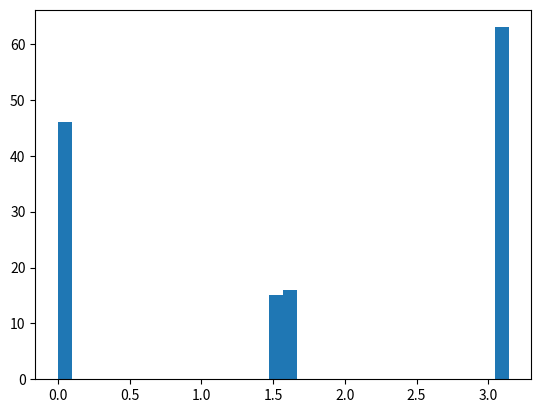

In [ ]:
import cv2


def get_document_orientation(
        np_img:          np.ndarray,
        min_line_length: float = 100,
        atol:            float = np.pi/8
        ):
    """
    Computes the document orientation using the lines detected by the Line Segment Detector.
    Args:
        np_img:          The input image
        min_line_length: The minimum line length to utilize the line
        atol:            The absolute tolerance to detect vertical / horizontal lines
    Returns:
        theta: float, document orientation in radians

    Methodology:
        - Compute the line segments using the Advanced refinement
        --> cv2 doc: "Number of false alarms is calculated, lines are refined through increase of precision, decrement in size, etc"
        - Only keep long lines
        - Filter them by orientation (keep vertical/horizontal lines)
        - Document orientation = mean of line orientations, weighted by line length
    """

    # Detect lines
    lsd = cv2.createLineSegmentDetector(cv2.LSD_REFINE_ADV)
    lines, width, prec, nfa = lsd.detect(img_np[...,0])


    dx = lines[..., 2]-lines[...,0]
    dy = lines[..., 3]-lines[...,1]

    lengths = (dy**2 + dx**2)**.5
    theta = np.arctan2(dx, dy) % np.pi

    # Keep big lines only
    mask = lengths > min_line_length
    theta = theta[mask]
    lengths = lengths[mask]

    # Filter by orientation
    oris = (0, np.pi/2, np.pi)

    lines_sum = 0
    for ori in oris:
        mask = np.isclose(theta, ori, atol=atol)
        lines_sum += np.sum(lengths[mask] * np.exp(2j * (theta[mask]-ori)))

    document_orientation = np.angle(lines_sum)
    return document_orientation


In [78]:
filtered_images = []

from src.patch_processing import filter_binary_patch

min_size_black=75,
min_size_white=20,

for bin_patch in tqdm.tqdm(patches_df['bin_patch']):
    #? Filter
    filtered = filter_binary_patch(
        bin_patch, 
        min_size_black=min_size_black, 
        min_size_white=min_size_white, 
    )

    filtered_images.append(filtered)

patches_df['filtered_bin_patch'] = filtered_images

ImportError: cannot import name 'filter_binary_patch' from 'src.patch_processing' (/home/mathis/Bureau/OCRProject/src/patch_processing/__init__.py)

**We now proceed to vectorizing the hànzi**

In [ ]:
from IPython.display import display, Markdown
from hydra.utils import instantiate
from operator import itemgetter
from omegaconf import OmegaConf
from src.patch_processing.normalization import compute_normalization_homography, compute_svg_normalization_homography
from src.patch_processing import filter_binary_patch
from IPython.display import SVG as IPYSVG
from tqdm import tqdm
os.environ["HYDRA_FULL_ERROR"] = "1"

from src.patch_processing.svg import SVG

# ==== Instantiate the vectorizer ====

#? See configs/vectorizer.yaml
cfg = compose(config_name="vectorizer")
vect = instantiate(cfg)

#? We show the content of the config 
display(Markdown(f"```yaml\n{OmegaConf.to_yaml(cfg)}\n```"))


#! ==== CACHING ====

if False:
    svg_imgs = []
    for i in tqdm(range(len(patches_df)), desc="Loading vectorized images", unit="img", colour='green'):
        svg_imgs.append(SVG.load(Path(cfg.config.save_dir) / f'output_{i:06d}.svg'))

#! ==== Vectorize the images ===

else:
    inverted = [p<.5 for p in patches_df['filtered_bin_patch']]
    svg_imgs = []
    for svg in tqdm(vect(inverted), total=len(inverted), desc="Vectorizing images", unit="img", colour='green'): # <-- iterator over the images | gathers data in parallel and yields it
        svg_imgs.append(svg)

    del inverted # free some memory

    svg_imgs = sorted(svg_imgs, key=itemgetter(0))
    svg_imgs = [el[1] for el in svg_imgs]

patches_df['svg'] = svg_imgs

2026-01-13 17:21:09,613 - INFO - Initialized vectorizer:
2026-01-13 17:21:09,613 - INFO -   output_size: (512, 512)
2026-01-13 17:21:09,614 - INFO -   background_color: (255, 255, 255, 255)
2026-01-13 17:21:09,614 - INFO -   output_format: L


```yaml
_target_: src.vectorization.BinaryShapeVectorizer
config:
  _target_: src.vectorization.VectorizerConfig
  executable_path: ./build/main
  smoothing_scale: 0.6
  accuracy_threshold: 1
  refinement_iterations: 0
  output_type: shape_merged
  return_svg: true
  return_svg_string: false
  return_rendered: false
  save_dir: ./outputs_svg
  output_size:
  - 512
  - 512
  background_color:
  - 255
  - 255
  - 255
  - 255
  dpi: 2048
  scale: 1.0
  output_format: L
  n_jobs: -1
  show_progress: true
  chunk_size: 100
  stream_results: true
  stream_parallel: true

```

2026-01-13 17:21:09,653 - INFO - Processing 1486 binarized images
2026-01-13 17:21:09,654 - INFO - First image shape: (115, 129), dtype: bool
Computing bounding boxes: 100%|██████████| 1486/1486 [00:00<00:00, 43316.88svg/s]

Image with max aspect ratio:  1132


In [ ]:
from src.patch_processing.normalization import compute_moment
from src.patch_processing import filter_binary_patch
from torch.utils.data import Dataset
from src.patch_processing.renderer import Renderer

svg_imgs = patches_df['svg']

dpi = 256
scale = 1

dataset = Renderer(
    svg_imgs=patches_df['svg'],
    scale=scale,
    dpi=dpi,
    bin_thresh=128,
    pad_to_multiple=24
)

# Access canvas dimensions
canvas_width = dataset.canvas_width
canvas_height = dataset.canvas_height
center_x = dataset.center_x
center_y = dataset.center_y

print(f"Canvas size: {canvas_width}×{canvas_height} pixels")

# Create DataLoader for batching
from torch.utils.data import DataLoader

dataloader = DataLoader(
    dataset,
    batch_size=256,
    shuffle=False,
    num_workers=0,  # Set to >0 if rendering is CPU-intensive
    pin_memory=True
)


# Or get individual images
N = 10
fig, axes = plt.subplots(N, N, figsize=(24, 24), constrained_layout=True)

for i, ax in enumerate(axes.flat):
    ax.axis('off')
    
    img = dataset[i].numpy()  # Get i-th image
    ax.imshow(img, cmap='gray', vmin=0, vmax=1, aspect='equal')
    ax.set_title(f'Image {i}', fontsize=10)
    
    ax.plot(center_x, center_y, 'r+', markersize=10, markeredgewidth=1.5)

plt.show()

savefig(fig, 'canvas')

Rendering: 100%|██████████| 1486/1486 [00:05<00:00, 265.81img/s]


Canvas dimensions: w=168, h=192, cx=86, cy=91
Canvas size: 168×192 pixels


2026-01-13 17:33:13,131 - WARNING - /tmp/ipykernel_6075/772028763.py:208: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()



PosixPath('report_figures/canvas/fig-000008.png')

In [10]:
from src.ocr.wrappers import available_wrappers, EnsembleOCR
from tqdm import tqdm
import pandas as pd

# initialize wrappers and ensemble
wrappers = available_wrappers()              # dict[name -> model]
ensemble = EnsembleOCR(wrappers)

# prepare columns in the dataframe
patches_df["ensemble_pred"] = ""
patches_df["ensemble_uncertainty"] = 0.0
patches_df["ensemble_probs"] = None          # dict: char -> prob
patches_df["individual_preds"] = None        # dict: model -> {char, score, uncertainty}

for idx in tqdm(range(len(patches_df)), desc="OCR Processing"):
    patch = patches_df["svg"].iloc[idx].render(output_format="L")

    results = ensemble.predict([patch])

    # ----- ensemble output -----
    ens = results["ensemble"][0]

    patches_df.at[idx, "ensemble_pred"] = ens["char"]
    patches_df.at[idx, "ensemble_uncertainty"] = ens["uncertainty"]
    patches_df.at[idx, "ensemble_probs"] = ens["probs"]

    # ----- individual outputs -----
    indiv_logged = {}

    for model_name, preds in results["individual"].items():
        p = preds[0]
        indiv_logged[model_name] = {
            "char": p["char"],
            "score": p["score"],
            "uncertainty": 1.0 - p["score"],
        }

    patches_df.at[idx, "individual_preds"] = indiv_logged


/home/mathis/anaconda3/envs/projetOCR/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2026-01-13 17:25:43,214 - INFO - use model: /home/mathis/.cnocr/2.3/densenet_lite_136-gru/cnocr-v2.3-densenet_lite_136-gru-epoch=004-ft-model.onnx
OCR Processing: 100%|██████████| 1486/1486 [05:11<00:00,  4.78it/s]


In [11]:
# import importlib

# import notebook_utils.parquet_utils as pu
# importlib.reload(pu)
# from notebook_utils.parquet_utils import load_columns

# ocr_columns = ['ensemble_pred', 'ensemble_uncertainty', 'ensemble_probs', 'individual_preds', 'predicted_char']
# ocr_data = load_columns('data/tmp/svg', ocr_columns)

# for col in ocr_columns:
#     patches_df[col] = ocr_data[col]

In [12]:
import easyocr
import numpy as np
from tqdm import tqdm

reader = easyocr.Reader(['ch_tra'], gpu=True, verbose=False)

print("Processing OCR...")
all_results = []

for idx in tqdm(range(len(patches_df)), desc="OCR Processing"):
    patch = patches_df['svg'].iloc[idx].render(output_format='RGB')
    if patch.dtype != np.uint8:
        patch = patch.astype(np.uint8)
    
    try:
        result = reader.readtext(patch, detail=0)
        all_results.append(result[0] if result else '')
    except:
        all_results.append('')

patches_df['predicted_char'] = all_results

del reader

Processing OCR...


OCR Processing: 100%|██████████| 1486/1486 [01:13<00:00, 20.31it/s]


In [13]:
from notebook_utils.parquet_utils import save_dataframe
save_dataframe(patches_df.drop(columns='svg'), 'data/tmp/svg')

Saving column: bin_patch
Saving column: img_patch
Saving column: page
Saving column: file
Saving column: left
Saving column: top
Saving column: width
Saving column: height
Saving column: label
Saving column: filtered_bin_patch
Saving column: ensemble_pred
Saving column: ensemble_uncertainty
Saving column: ensemble_probs
Saving column: individual_preds
Saving column: predicted_char
✓ Saved to data/tmp/svg


In [14]:
# from notebook_utils.parquet_utils import load_dataframe
# from src.patch_processing.svg import SVG

# patches_df = load_dataframe('data/tmp/svg')
# patches_df['svg'] = patches_df['svg_str'].map(lambda s: SVG.load_from_string(s))

## Computing the HOG descriptor

We now explain how we compute the HOG descriptor to match the different patches to characters.

The computation is done as follows:

1. Preprocessing step

The images on which we wish to compute the descriptors are preprocessed.
It is possible to compute the descriptors on either grayscale images or multi-channel images. We use grayscale conversion.
We also resize the images to a fixed size.

2. Computing the gradients

There are several ways to compute the gradients. We first begin by using a gaussian filter to smooth the image.
Then, we apply a separable convolution based on cv2.getDerivKernels to compute the image gradients. The two components of this separable convolutions are:
- A smoothing operator on one axis
- It's derivative on the other axis

This is justified because of derivative operations on convolution products.:

$$\frac{\partial}{\partial x}(I * G) = I * \frac{\partial G}{\partial x}$$

For a 2D Gaussian $G(x,y) = G_x(x) \cdot G_y(y)$, the x-gradient becomes:

$$
\frac{\partial}{\partial x}(I * G) = I * \left(\frac{\partial G_x}{\partial x} \otimes G_y\right)
$$

where $\otimes$ denotes separable convolution: first convolve rows with $G_y$ (smooth), then columns with $\frac{\partial G_x}{\partial x}$ (differentiate).

3. Histogram Computation

We begin by computing:
- The orientation of the gradients in the image: $\theta = \text{arctan2}(dx, dy)$
- Their magnitude: $M = \sqrt{{dx}^2 + {dy}^2}$

We rearrange these arrays of shape $(H, W)$ to $(\text{Nh}, \text{Nw}, h, w)$, with Nh and Nw the number of rows / cols of cells, $h$ and $w$ their height and width

We will use trilinear interpolation to compute the histograms.
For each pixel $u$ of the cell, we compute the two bins the cell should contribute to:

$$i_1 = \lfloor\theta_u \cdot N_{\text{bins}}\rfloor \quad ; \quad i_2 = i_1 + 1$$

The contribution weights for angular interpolation are:
$$w_2 = \theta_u \cdot N_{\text{bins}} - i_1 \quad ; \quad w_1 = 1 - w_2$$

Optionally, a Gaussian spatial weighting can be applied (used in SIFT, but not in standard HOG):
$$w_{\text{spatial}}(x, y) = \exp\left(-\frac{x_n^2 + y_n^2}{2\sigma^2}\right)$$
where $(x_n, y_n) \in [-1, 1]^2$ are normalized coordinates from the cell center.

Each pixel contributes to the histogram:
$$H[i_1] \mathrel{+}= M_u \cdot w_1 \cdot w_{\text{spatial}} \quad ; \quad H[i_2] \mathrel{+}= M_u \cdot w_2 \cdot w_{\text{spatial}}$$

4. Normalization

As in SIFT, the descriptors can be optionally normalized.
We can normalize them:
- At cell-level: normalize each histogram to be unit norm (as done in SIFT)
- At patch-level: normalize the vector of concatenated

[This paper](https://www.ipol.im/pub/art/2014/82/article.pdf), Anatomy of the SIFT method, states that cell-level normalization can help with lightning changes.
We don't have such lightning changes, and have small cells. We therefore prefeer to use patch-level normalization. 

As in SIFT, we clip the values of the descriptors to be in the $[-0.2, 0.2]$ range, before re-normalizing the descriptors.

In [17]:
hog_params = HOGParameters(
    device          = "cuda",
    C               = 1,                        # Use grayscale images
    partial_output  = False,                    # Also output the resized images, their gradient orientation and magnitude
    method          = 'gaussian',               # Use gaussian smoothing to compute the gradients
    grdt_sigma      = 5,                      # Std of the smoothing
    ksize_factor    = 6,                        # Size of the smoothing kernel = factor * std
    cell_height     = 24,                       # Size of the cells to compute the histograms
    cell_width      = 24,
    num_bins        = 16,                        # Number of bins
    threshold       = 0.2,                      # Clip the values of the descriptor
    normalize       = 'patch'                   # Normalize at patch-level. SIFT uses cell-level descriptor normalization
)

from src.character_linking.hog import HOG


first_batch = next(iter(dataloader))


hog = HOG(hog_params)
hogOutput = hog(first_batch.unsqueeze(1).to(dtype=torch.float32, device='cuda'))

histograms_first_batch = hogOutput.histograms[:, 0]


fft convolution ; scipy 

In [18]:

# for _ in range(10):
i = np.random.randint(0, len(histograms_first_batch))
    # i = 98
    # i = 220

fig = visualize_hog(hog_params, histograms_first_batch, first_batch, hogOutput, i)
    # savefig(fig, 'hog')

Visualizing patch 240
Grid: 8 x 7 cells, each with 16 orientation bins
Cell size: 24 x 24 pixels


2026-01-13 17:33:20,206 - WARNING - /home/mathis/Bureau/OCRProject/notebook_utils/descriptor.py:265: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()

2026-01-13 17:33:20,298 - WARNING - /home/mathis/Bureau/OCRProject/notebook_utils/descriptor.py:293: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()




Histogram Statistics:
  Min: 0.0000
  Max: 0.2011
  Mean: 0.0148
  L2 norm: 1.0000


In [19]:
from src.character_linking.hog import HOG


first_batch = next(iter(dataloader))


hog = HOG(hog_params)

# Get the total number of samples and histogram shape
total_samples = len(dataloader.dataset)
sample_output = hog(first_batch[:1].unsqueeze(1).to(dtype=torch.float32, device='cuda'))
histogram_shape = sample_output.histograms[0, 0].shape

histograms = torch.zeros((total_samples, *histogram_shape), device='cuda')

# Fill progressively
start_idx = 0
for batch in tqdm(dataloader):
    hogOutput = hog(batch.unsqueeze(1).to(dtype=torch.float32, device='cuda'))
    histogram_batch = hogOutput.histograms[:, 0]
    
    batch_size = histogram_batch.shape[0]
    histograms[start_idx:start_idx + batch_size] = histogram_batch
    start_idx += batch_size
    
patches_df['histogram'] = histograms.cpu().numpy()

100%|██████████| 6/6 [00:05<00:00,  1.07it/s]


**Let's look at a t-sne plot of the histograms to see if we can observe some clusters:**

In [20]:
# X = patches_df['histogram'].reshape(histograms.shape[0], -1)[:10000]
# X.shape

# from sklearn.manifold import TSNE

# tsne = TSNE(n_components=2, random_state=42)
# X_embedded = tsne.fit_transform(X)

# plt.figure(figsize=(10,10))
# plt.scatter(X_embedded[:, 0], X_embedded[:, 1], s=1)
# plt.xlabel('t-SNE 1')
# plt.ylabel('t-SNE 2')
# plt.title('t-SNE Plot')
# plt.show()


**We apply d-reduction to run our algorithms faster:**

In [21]:
# X = rearrange(histograms.cpu(), 'B N_h N_b -> B (N_h N_b)')

# N_KEPT = 100

# from sklearn.decomposition import PCA
# pca = PCA(n_components=300)
# pca.fit(X)

# import matplotlib.pyplot as plt

# cum_var = pca.explained_variance_ratio_.cumsum()
# kept_var = cum_var[N_KEPT - 1]

# plt.figure(figsize=(8, 5))
# plt.stairs(cum_var, linewidth=2)
# plt.axhline(0.9, color='r', linestyle='--', alpha=0.5, label='90% variance')
# plt.axvline(N_KEPT, color='g', linestyle='--', alpha=0.5, 
#             label=f'{N_KEPT} components ({kept_var:.1%} var)')
# plt.axhline(kept_var, color='g', linestyle=':', alpha=0.3)
# plt.xlabel('N components')
# plt.ylabel('Cumulative explained variance')
# plt.title('PCA Explained Variance')
# plt.grid(alpha=0.3)
# plt.legend()
# plt.tight_layout()

# # Project onto N_KEPT components and reconstruct to original space
# X_reduced = pca.transform(X)[:, :N_KEPT]
# X_reconstructed = X_reduced @ pca.components_[:N_KEPT] + pca.mean_

# histograms = rearrange(torch.tensor(X_reconstructed), 'B (N_h N_b) -> B N_h N_b', 
#                        N_h=histograms.shape[1], N_b=histograms.shape[2]).to(device=histograms.device,dtype=histograms.dtype)

In [22]:
# X = histograms.reshape(histograms.shape[0], -1).cpu().numpy()
# X.shape

# from sklearn.manifold import TSNE

# tsne = TSNE(n_components=2, random_state=42)
# X_embedded = tsne.fit_transform(X)

# plt.figure(figsize=(15,15))
# plt.scatter(X_embedded[:, 0], X_embedded[:, 1], s=1)
# plt.xlabel('t-SNE 1')
# plt.ylabel('t-SNE 2')
# plt.title('t-SNE Plot')
# plt.show()


In [23]:
# i = np.random.randint(0, len(histograms_first_batch))
# hog = HOG(hog_params)
# hogOutput = hog(first_batch.unsqueeze(1).to(dtype=torch.float32, device='cuda'))

# # visualize_hog(hog_params, histograms_first_batch, first_batch, hogOutput, i)

# X = rearrange(histograms_first_batch.cpu(), 'B N_h N_b -> B (N_h N_b)')
# X_reduced = pca.transform(X)[:, :N_KEPT]
# X_reconstructed = X_reduced @ pca.components_[:N_KEPT] + pca.mean_

# histograms_proj = rearrange(torch.tensor(X_reconstructed), 'B (N_h N_b) -> B N_h N_b', 
#                        N_h=histograms.shape[1], N_b=histograms.shape[2]).to(device=histograms.device,dtype=histograms.dtype)


# viz_only_hog(hog_params, histograms_first_batch, histograms_proj, img=first_batch[i], patch_idx=i)
# print('a')
# # visualize_hog(hog_params, histograms_proj, first_batch, hogOutput, i)


In [20]:
patches_df['svg'] = svg_imgs
patches_df['histogram'] = list(histograms.cpu().numpy())
from notebook_utils.parquet_utils import save_dataframe
save_dataframe(patches_df, 'data/processed/book1_columnwise')

Saving column: bin_patch
Saving column: img_patch
Saving column: page
Saving column: file
Saving column: left
Saving column: top
Saving column: width
Saving column: height
Saving column: label
Saving column: filtered_bin_patch
Saving column: svg
Saving column: ensemble_pred
Saving column: ensemble_uncertainty
Saving column: ensemble_probs
Saving column: individual_preds
Saving column: predicted_char
Saving column: histogram
✓ Saved to data/processed/book1_columnwise
